# Denoising by proximal solvers - as in Chambolle paper

We try to solve the following problem (as in Pock and Chambolle paper):

$$
arg \;  min_\mathbf{u} \frac{\lambda}{2}||\mathbf{u-f}||_2^2 + J(\mathbf{u})
$$

with different choices of regularization:

- L2 on Gradient $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_2^2$
- Anisotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1$
- Anisotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1 - \mathbf{p}_k^T \mathbf{u}$
- Isotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1}$
- Isotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1} - \mathbf{p}_k^T \mathbf{u}$

**Note**: the main difference with the ``Denoising`` notebook lies in the fact that we add here a weight to the data term $\frac{\lambda}{2}$ instead of the regularization term.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy import datasets
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

np.random.seed(0)

Data and operators preparation

In [2]:
# Load image
img = datasets.ascent()
img = img/np.max(img)
ny, nx = img.shape

# Add noise
sigman = 0.2
n = sigman*np.max(abs(img.ravel()))*np.random.uniform(-1,1, img.shape)
#n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

In [3]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

# Data term scaling
lamda = 8.

### L2 on Gradient

In [4]:
# L2 data term
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L2 regularization
sigma = 100.
thik = L2(sigma=sigma)

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = 1. / (tau*L)

iml2 = LinearizedADMM(l2, thik, Gop, tau=tau, mu=mu, x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml2 = iml2.reshape(img.shape)

### Anisotropic TV

In [5]:
# L2 data term
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# Anisotropic TV
l1 = L1()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = tau / L

iml1 = LinearizedADMM(l2, l1, Gop, tau=tau, mu=mu, 
                      x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml1 = iml1.reshape(img.shape)

### Anisotropic TV + Bregman iterations

In [6]:
# L2 data term
sigma = 10.
l2 = L2(b=noise_img.ravel(), sigma=lamda, alpha=sigma, qgrad=False)

# Anisotropic TV
l1 = L1(sigma=sigma)

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = tau / L

iml1b = Bregman(l2, l1, A=Gop, x0=np.zeros_like(img.ravel()), 
                solver=LinearizedADMM, niterouter=10,
                **dict(tau=tau, mu=mu, niter=50))
iml1b = iml1b.reshape(img.shape)

### Isotropic TV with Primal-Dual

In [7]:
# L2 data term
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 0.01
mu = 1. / (tau*L)

iml12 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                   x0=np.zeros_like(img.ravel()), 
                   niter=400, show=True)
iml12 = iml12.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau = 0.01		mu = 12.5
theta = 1.00		niter = 400

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   2.55567e-02   1.507e+05   4.295e+03   0.000e+00       1.550e+05
     2   5.16062e-02   1.312e+05   4.085e+03   0.000e+00       1.353e+05
     3   7.71570e-02   1.150e+05   3.499e+03   0.000e+00       1.185e+05
     4   1.01506e-01   1.012e+05   3.220e+03   0.000e+00       1.044e+05
     5   1.24231e-01   8.921e+04   3.209e+03   0.000e+00       9.242e+04
     6   1.44967e-01   7.885e+04   3.293e+03   0.000e+00       8.214e+04
     7   1.63469e-01   6.988e+04   3.404e+03   0.000e+00       7.328e+04
     8   1.79670e-01   6.214e+04   3.534e+03   

### Isotropic TV + Bregman iterations

In [8]:
sigma = 10.
l2 = L2(b=noise_img.ravel(), sigma=lamda, alpha=sigma, qgrad=False)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2, sigma=sigma)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
#tau = 1 / np.sqrt(L)
#mu = 1 / np.sqrt(L)
tau = 0.01
mu = 1. / (tau*L)

iml12b = Bregman(l2, l1iso, A=Gop, x0=np.zeros_like(img.ravel()), 
                 solver=PrimalDual, niterouter=10,
                 **dict(tau=tau, mu=mu, theta=1., niter=50))
iml12b = iml12b.reshape(img.shape)

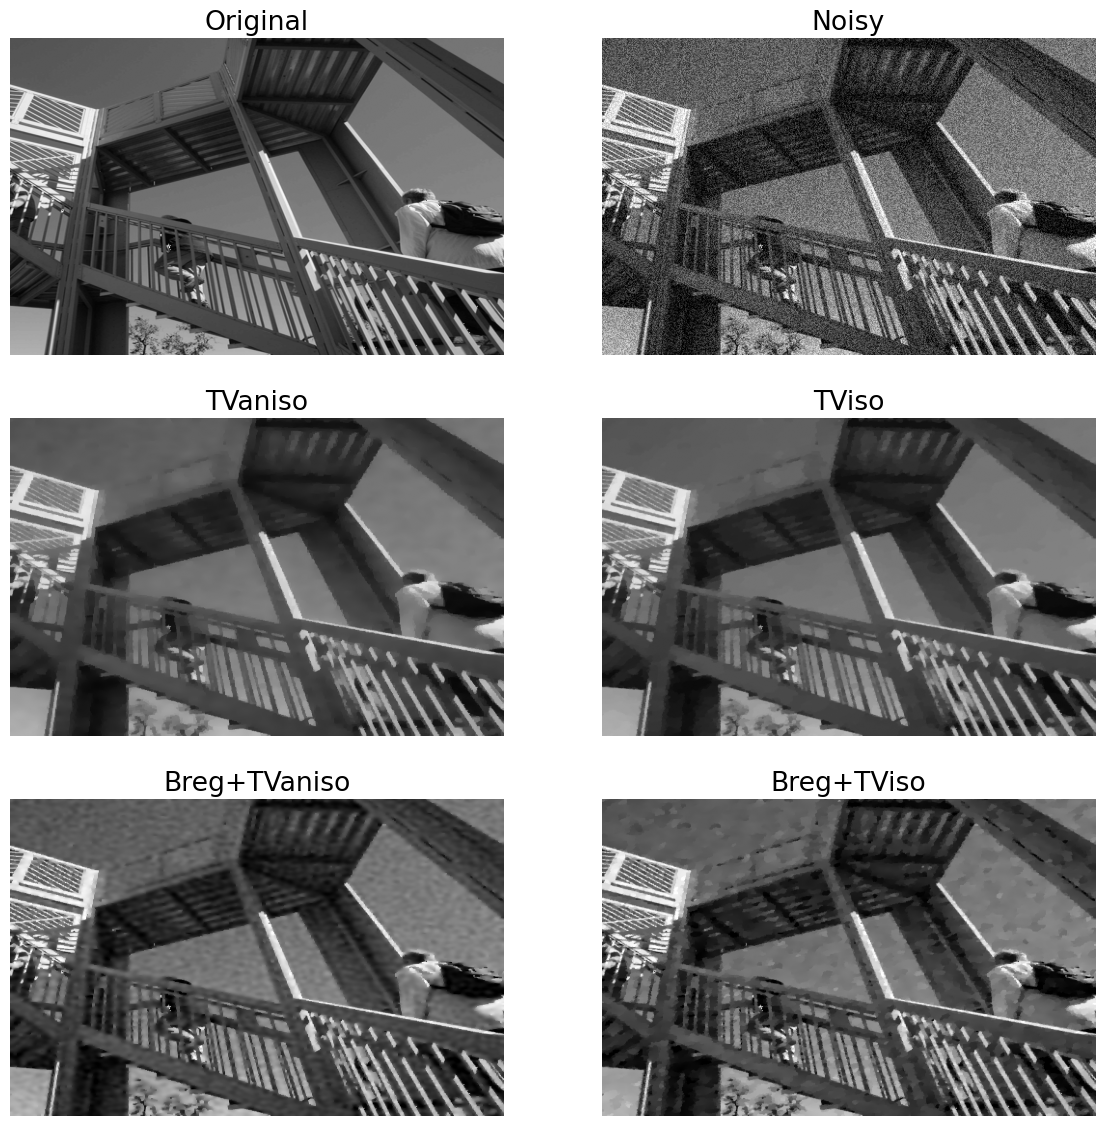

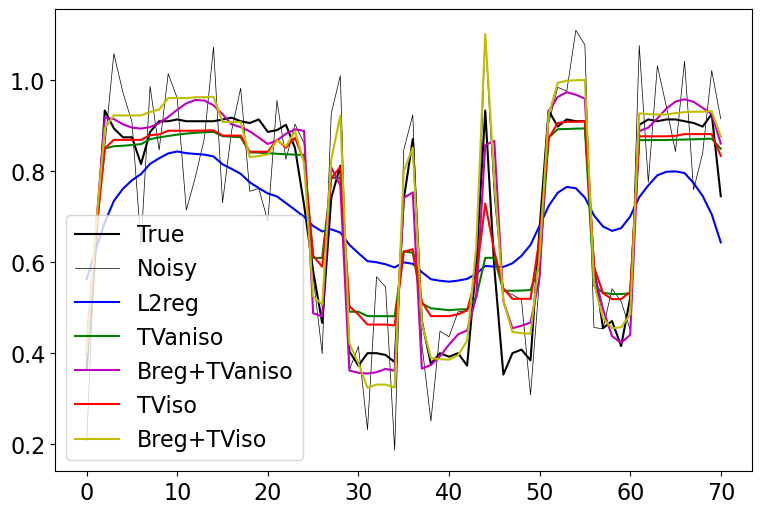

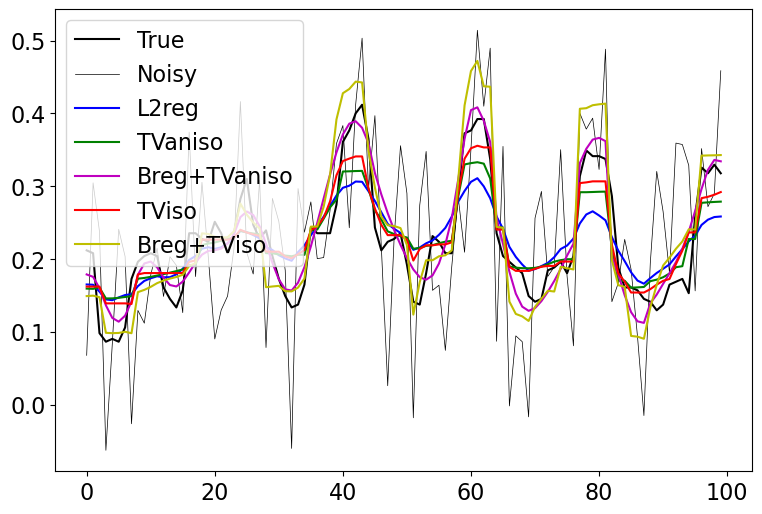

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
axs[0][0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][0].axis('tight')
axs[0][1].imshow(noise_img, cmap='gray', vmin=0, vmax=1)
axs[0][1].set_title('Noisy')
axs[0][1].axis('off')
axs[0][1].axis('tight')
axs[1][0].imshow(iml1, cmap='gray', vmin=0, vmax=1)
axs[1][0].set_title('TVaniso')
axs[1][0].axis('off')
axs[1][0].axis('tight')
axs[1][1].imshow(iml12, cmap='gray', vmin=0, vmax=1)
axs[1][1].set_title('TViso')
axs[1][1].axis('off')
axs[1][1].axis('tight');
axs[2][0].imshow(iml1b, cmap='gray', vmin=0, vmax=1)
axs[2][0].set_title('Breg+TVaniso')
axs[2][0].axis('off')
axs[2][0].axis('tight')
axs[2][1].imshow(iml12b, cmap='gray', vmin=0, vmax=1)
axs[2][1].set_title('Breg+TViso')
axs[2][1].axis('off')
axs[2][1].axis('tight')

ix_min = 84
ix_max = 155
iy = 20
plt.figure(figsize=(9, 6))
plt.plot(img[ix_min:ix_max, iy], 'k', label='True')
plt.plot(noise_img[ix_min:ix_max, iy], 'k', lw=0.5, label='Noisy')
plt.plot(iml2[ix_min:ix_max, iy], 'b', label='L2reg')
plt.plot(iml1[ix_min:ix_max, iy], 'g', label='TVaniso')
plt.plot(iml1b[ix_min:ix_max, iy], 'm', label='Breg+TVaniso')
plt.plot(iml12[ix_min:ix_max, iy], 'r', label='TViso')
plt.plot(iml12b[ix_min:ix_max, iy], 'y', label='Breg+TViso')
plt.legend();

ix = 50
iy_min = 250
iy_max = 350
plt.figure(figsize=(9, 6))
plt.plot(img[ix, iy_min:iy_max], 'k', label='True')
plt.plot(noise_img[ix, iy_min:iy_max], 'k', lw=0.5, label='Noisy')
plt.plot(iml2[ix, iy_min:iy_max], 'b', label='L2reg')
plt.plot(iml1[ix, iy_min:iy_max], 'g', label='TVaniso')
plt.plot(iml1b[ix, iy_min:iy_max], 'm', label='Breg+TVaniso')
plt.plot(iml12[ix, iy_min:iy_max], 'r', label='TViso')
plt.plot(iml12b[ix, iy_min:iy_max], 'y', label='Breg+TViso')
plt.legend();

## Salt and Pepper noise

At this point we have considered random noise. We will deal now with salt and pepper noise (which is 0 and 1 spikes added randomly to the image.

It turns out that in this case switching from a L2 norm to a L1 norm on the data term can be used to further improve our denoising capabilities:


$$
arg \;  min_\mathbf{u} \lambda||\mathbf{u-f}||_1 + J(\mathbf{u})
$$

In [10]:
# Load image
img = datasets.ascent()
#img = 2*img/np.max(img) - 1.
img = img/np.max(img)
ny, nx = img.shape

# Add salt and pepper noise
noiseperc = 0.1

isalt = np.random.permutation(np.arange(ny*nx))[:int(noiseperc*ny*nx)]
ipepper = np.random.permutation(np.arange(ny*nx))[:int(noiseperc*ny*nx)]
noise_img = img.copy().ravel()
noise_img[isalt] = img.max()
noise_img[ipepper] = img.min()
noise_img = noise_img.reshape(ny,nx)

In [11]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

### L2 data norm with Isotropic TV

In [12]:
# L2 data term
lamda = 4.
l2 = L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
#tau = 1 / np.sqrt(L)
#mu = 1 / np.sqrt(L)
tau = .1
mu = 1. / (tau*L)

iml12_l2 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., x0=np.zeros_like(noise_img).ravel(), 
                      niter=400, show=True)
iml12_l2 = iml12_l2.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau = 0.1		mu = 1.25
theta = 1.00		niter = 400

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   9.29972e-02   5.748e+04   2.316e+04   0.000e+00       8.064e+04
     2   1.59224e-01   3.708e+04   2.397e+04   0.000e+00       6.105e+04
     3   2.00426e-01   2.946e+04   1.991e+04   0.000e+00       4.937e+04
     4   2.27602e-01   2.685e+04   1.584e+04   0.000e+00       4.270e+04
     5   2.49171e-01   2.619e+04   1.294e+04   0.000e+00       3.913e+04
     6   2.68531e-01   2.618e+04   1.104e+04   0.000e+00       3.722e+04
     7   2.86377e-01   2.632e+04   9.741e+03   0.000e+00       3.606e+04
     8   3.02443e-01   2.647e+04   8.802e+03   0

### L1 data norm with Isotropic TV

In [13]:
# L1 data term
lamda = 1.5
l1 = L1(g=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
#tau = 1 / np.sqrt(L)
#mu = 1 / np.sqrt(L)
tau = 1.
mu = 1. / (tau*L)

iml12_l1 = PrimalDual(l1, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                      x0=np.zeros_like(noise_img).ravel(), #x0=noise_img.ravel(), 
                      niter=100, show=True)
iml12_l1 = iml12_l1.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau = 1.0		mu = 0.125
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.25490e-01   1.446e+05   8.107e+04   0.000e+00       2.257e+05
     2   3.25490e-01   1.446e+05   8.107e+04   0.000e+00       2.257e+05
     3   3.25490e-01   1.446e+05   8.107e+04   0.000e+00       2.257e+05
     4   3.25490e-01   1.428e+05   7.611e+04   0.000e+00       2.189e+05
     5   3.25490e-01   1.374e+05   6.031e+04   0.000e+00       1.977e+05
     6   3.25490e-01   1.320e+05   4.669e+04   0.000e+00       1.787e+05
     7   3.25490e-01   1.290e+05   4.079e+04   0.000e+00       1.697e+05
     8   3.25490e-01   1.275e+05   3.558e+04   

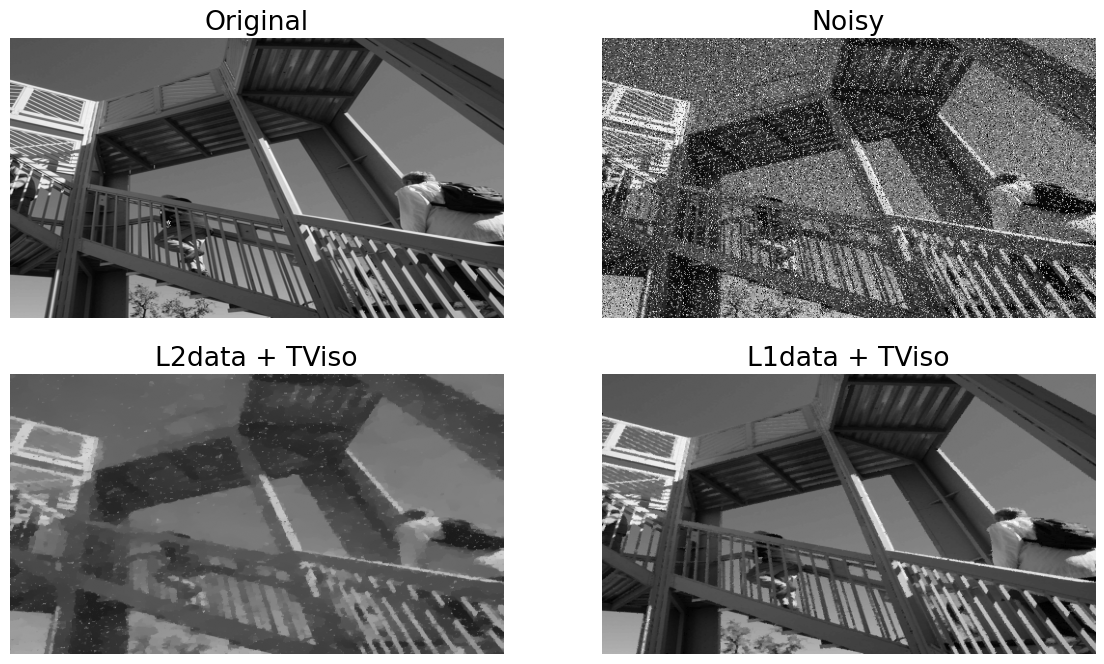

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0][0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][0].axis('tight')
axs[0][1].imshow(noise_img, cmap='gray', vmin=0, vmax=1)
axs[0][1].set_title('Noisy')
axs[0][1].axis('off')
axs[0][1].axis('tight')
axs[1][0].imshow(iml12_l2, cmap='gray', vmin=0, vmax=1)
axs[1][0].set_title('L2data + TViso')
axs[1][0].axis('off')
axs[1][0].axis('tight')
axs[1][1].imshow(iml12_l1, cmap='gray', vmin=0, vmax=1)
axs[1][1].set_title('L1data + TViso')
axs[1][1].axis('off')
axs[1][1].axis('tight');